In [3]:
import netgen.gui
from ngsolve import *
import numpy as np
from time import time
import matplotlib.pyplot as plt

from ngsolve.solvers import CG
from ngsolve.la import EigenValues_Preconditioner

In [4]:
from netgen.geom2d import unit_square
# Why that specific h?
h = 0.01
mesh = Mesh(unit_square.GenerateMesh(maxh=h))
Draw (mesh)

In [5]:
fes = H1(mesh, order=3,dirichlet=".*") # dirichlet on all boundaries
gfu_a = GridFunction(fes,name = "u_a")
gfu_b = GridFunction(fes,name = "u_b")

In [6]:
#### Without preconditioner #####
# Eq a)
ua = fes.TrialFunction()
va = fes.TestFunction()

Aa = BilinearForm(fes)
Fa = LinearForm(fes)
Aa += ua*va*dx
Fa += va*dx

Aa.Assemble()
Fa.Assemble()

aruntime_without_precond = time()
with TaskManager():
    gfu_a.vec.data = Aa.mat.Inverse(fes.FreeDofs()) * Fa.vec
aruntime_without_precond = time() - aruntime_without_precond

# Eq b)
ub = fes.TrialFunction()
vb = fes.TestFunction()

Ab = BilinearForm(fes)
Fb = LinearForm(fes)
Ab += grad(ub)*grad(vb)*dx
Fb += vb*dx

Ab.Assemble()
Fb.Assemble()

bruntime_without_precond = time()
with TaskManager():
    gfu_b.vec.data = Ab.mat.Inverse(fes.FreeDofs()) * Fb.vec
bruntime_without_precond = time() - bruntime_without_precond

    
Draw(gfu_a, mesh, "no precond")
Draw(gfu_b, mesh, "no precond")


In [7]:
##### WITH Preconditioner
# Eq a)
ua = fes.TrialFunction()
va = fes.TestFunction()

Aa = BilinearForm(fes)
Fa = LinearForm(fes)

Aa += ua*va*dx

Fa += va*dx

Aa.Assemble()
Fa.Assemble()

aruntime_precond_setup = time()
# Jacobi preconditioner
#                  Aa...bilinear form
c = Preconditioner(Aa,"local",test = True)
c.Update()
aruntime_precond_setup = time() - aruntime_precond_setup

aruntime_with_precond = time()
with TaskManager():
    #gfu_a.vec.data = Aa.mat.Inverse(fes.FreeDofs()) * Fa.vec
    CG (mat=Aa.mat, pre=c.mat, rhs=Fa.vec, sol=gfu_a.vec, printrates=True, maxsteps=10000,tol=1e-9)
aruntime_with_precond = time() - aruntime_with_precond
    
# Eq b)
ub = fes.TrialFunction()
vb = fes.TestFunction()

Ab = BilinearForm(fes)
Fb = LinearForm(fes)

Ab += grad(ub)*grad(vb)*dx

Fb += vb*dx

Ab.Assemble()
Fb.Assemble()

bruntime_precond_setup = time()
# Jacobi preconditioner
#                  Aa...bilinear form
cb = Preconditioner(Ab,"local",test = True)
cb.Update()
bruntime_precond_setup = time() - bruntime_precond_setup

bruntime_with_precond = time()
with TaskManager():
    #gfu_b.vec.data = Ab.mat.Inverse(fes.FreeDofs()) * Fb.vec
    CG (mat=Ab.mat, pre=cb.mat, rhs=Fb.vec, sol=gfu_b.vec,printrates=True, maxsteps=10000,tol=1e-9)
bruntime_with_precond = time() - bruntime_with_precond


Draw(gfu_a, mesh, "precond")
Draw(gfu_b, mesh, "precond")

iteration 0 error = 2.1284679550020535
iteration 1 error = 0.11470486792385244
iteration 2 error = 0.1263220504049782
iteration 3 error = 0.1261223246854291
iteration 4 error = 0.07177830429838801
iteration 5 error = 0.030077206351151877
iteration 6 error = 0.013849236358053619
iteration 7 error = 0.009783054637130922
iteration 8 error = 0.012907866878931275
iteration 9 error = 0.021591129163241223
iteration 10 error = 0.027417305445015507
iteration 11 error = 0.01869437447610635
iteration 12 error = 0.011930857261126413
iteration 13 error = 0.010396144312984123
iteration 14 error = 0.008902778039269572
iteration 15 error = 0.005253139648736518
iteration 16 error = 0.0036278218041328443
iteration 17 error = 0.003428400291594467
iteration 18 error = 0.0028450519844320176
iteration 19 error = 0.0016429159153719848
iteration 20 error = 0.0009827947220073345
iteration 21 error = 0.0007749029514903254
iteration 22 error = 0.000764870371737188
iteration 23 error = 0.0006709756437152965
itera

In [8]:
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ["method", "runtime solver", "runtime setup"]
table.float_format = ".3"
table.add_row(["a)", "-"*10, "-"*10])
table.add_row(["direct inverse", aruntime_without_precond, 0])
table.add_row(["CG with Jacobi Precond", aruntime_with_precond, aruntime_precond_setup])
table.add_row(["b)", "-"*10, "-"*10])
table.add_row(["direct inverse", bruntime_without_precond, 0])
table.add_row(["CG with Jacobi Precond", bruntime_with_precond, bruntime_precond_setup])
print(table)

+------------------------+----------------+---------------+
|         method         | runtime solver | runtime setup |
+------------------------+----------------+---------------+
|           a)           |   ----------   |   ----------  |
|     direct inverse     |     1.545      |       0       |
| CG with Jacobi Precond |     0.268      |     0.128     |
|           b)           |   ----------   |   ----------  |
|     direct inverse     |     1.499      |       0       |
| CG with Jacobi Precond |     0.972      |     0.134     |
+------------------------+----------------+---------------+


---

# Condition number under mesh refinement

In [ ]:
j = 0
num_b = []
kappa_b = []
h_base = 0.5
maxlevel = 8
levels = [i for i in range(0,maxlevel)]
hs_b = []

mesh = Mesh(unit_square.GenerateMesh(maxh=h_base))
fes = H1(mesh, order=3,dirichlet=".*")
gfu_b = GridFunction(fes,name = "u_b")
ub = fes.TrialFunction()
vb = fes.TestFunction()

Ab = BilinearForm(fes)
Fb = LinearForm(fes)

Ab += grad(ub)*grad(vb)*dx

Fb += vb*dx

Ab.Assemble()
Fb.Assemble()

c = Preconditioner(Ab,"local",test = True)


for level in levels:
    if level > 0:
        mesh.Refine()
        
       
    fes.Update()
    gfu_b.Update()
    h = fes.ndof
    print("maxh:",h)
    Ab.Assemble()
    Fb.Assemble()
    c.Update()
    # Container for storing the number of iterations performed by the CG and the error
    data = []
    # needed for the callback function
    callback = lambda k,r: data.append((k,r))
    #gfu_a.vec.data = Aa.mat.Inverse(fes.FreeDofs()) * Fa.vec

    with TaskManager():
        CG (mat=Ab.mat, pre=c.mat, rhs=Fb.vec, sol=gfu_b.vec, printrates=False, maxsteps=10000,tol=1e-17, callback = callback)
    
    hs_b.append(h)
    num_b.append(len(data))
    lams = EigenValues_Preconditioner(mat=Ab.mat, pre=c)
    kappa_b.append(max(lams)/min(lams))
    
print("Iterations:", maxlevel)
Draw (mesh)
Draw(gfu_b)

In [10]:
j = 0
num_a = []
kappa_a = []
hs = [0.5**i for i in range(1,9)]

for i, h in enumerate(hs):
    mesh = Mesh(unit_square.GenerateMesh(maxh=h))
    fes = H1(mesh, order=3,dirichlet=".*")
    gfu_a = GridFunction(fes,name = "u_a")
    ua = fes.TrialFunction()
    va = fes.TestFunction()

    Aa = BilinearForm(fes)
    Fa = LinearForm(fes)

    Aa += ua*va*dx

    Fa += va*dx

    Aa.Assemble()
    Fa.Assemble()

    c = Preconditioner(Aa,"local",test = True)

    print(f"ref_#: {i}, maxh: {h}")
    Aa.Assemble()
    Fa.Assemble()
    c.Update()
    data = []
    callback = lambda k,r: data.append((k,r))
    #gfu_a.vec.data = Aa.mat.Inverse(fes.FreeDofs()) * Fa.vec

    with TaskManager():
        CG (mat=Aa.mat, pre=c.mat, rhs=Fa.vec, sol=gfu_a.vec, printrates=False, maxsteps=10000, tol=1e-15, callback = callback)

    num_a.append(len(data))
    lams = EigenValues_Preconditioner(mat=Aa.mat, pre=c)
    kappa_a.append(max(lams)/min(lams))

print("Iterations:", len(hs))
Draw (mesh)
Draw(gfu_a)

ref_#: 0, maxh: 0.5
ref_#: 1, maxh: 0.25
ref_#: 2, maxh: 0.125
ref_#: 3, maxh: 0.0625
ref_#: 4, maxh: 0.03125
ref_#: 5, maxh: 0.015625
ref_#: 6, maxh: 0.0078125
ref_#: 7, maxh: 0.00390625
Iterations: 8


In [11]:
num_b = []
kappa_b = []
hs = [0.5**i for i in range(1,9)]


for i, h in enumerate(hs):
    mesh = Mesh(unit_square.GenerateMesh(maxh=h))
    fes = H1(mesh, order=3,dirichlet=".*")
    gfu_b = GridFunction(fes,name = "u_b")
    ub = fes.TrialFunction()
    vb = fes.TestFunction()

    Ab = BilinearForm(fes)
    Fb = LinearForm(fes)

    Ab += grad(ub)*grad(vb)*dx

    Fb += vb*dx

    Ab.Assemble()
    Fb.Assemble()

    c = Preconditioner(Ab,"local",test = True)

    print(f"ref_#: {i}, maxh: {h}")
    Ab.Assemble()
    Fb.Assemble()
    c.Update()
    data = []
    callback = lambda k,r: data.append((k,r))
    #gfu_a.vec.data = Aa.mat.Inverse(fes.FreeDofs()) * Fa.vec

    with TaskManager():
        CG (mat=Ab.mat, pre=c.mat, rhs=Fb.vec, sol=gfu_b.vec, printrates=False, maxsteps=10000, tol=1e-15, callback = callback)
    
    num_b.append(len(data))
    lams = EigenValues_Preconditioner(mat=Ab.mat, pre=c)
    kappa_b.append(max(lams)/min(lams))

print("Iterations:", len(hs))
Draw (mesh)
Draw(gfu_b)

ref_#: 0, maxh: 0.5
ref_#: 1, maxh: 0.25
ref_#: 2, maxh: 0.125
ref_#: 3, maxh: 0.0625
ref_#: 4, maxh: 0.03125
ref_#: 5, maxh: 0.015625
ref_#: 6, maxh: 0.0078125
ref_#: 7, maxh: 0.00390625
Iterations: 8


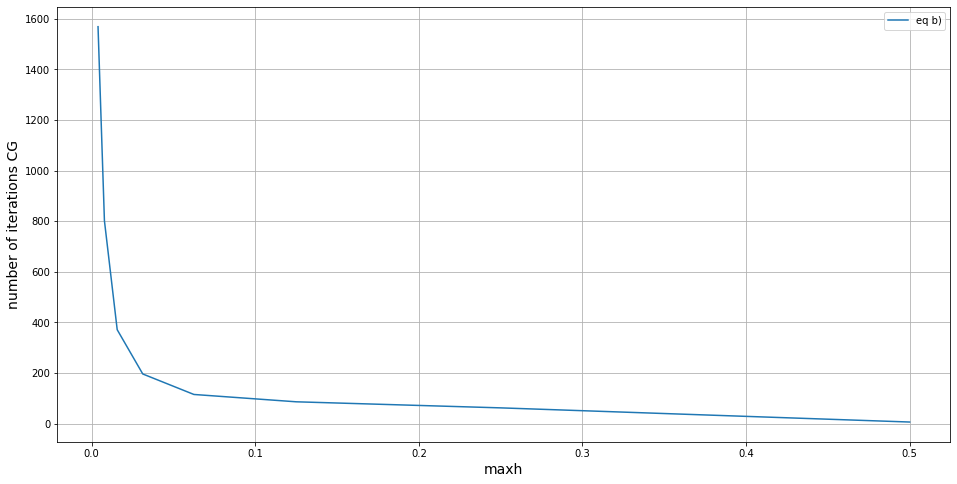

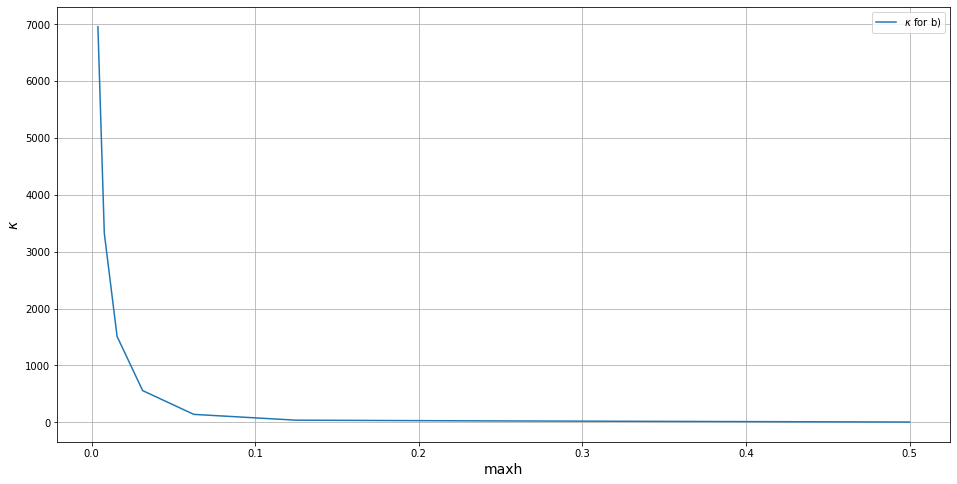

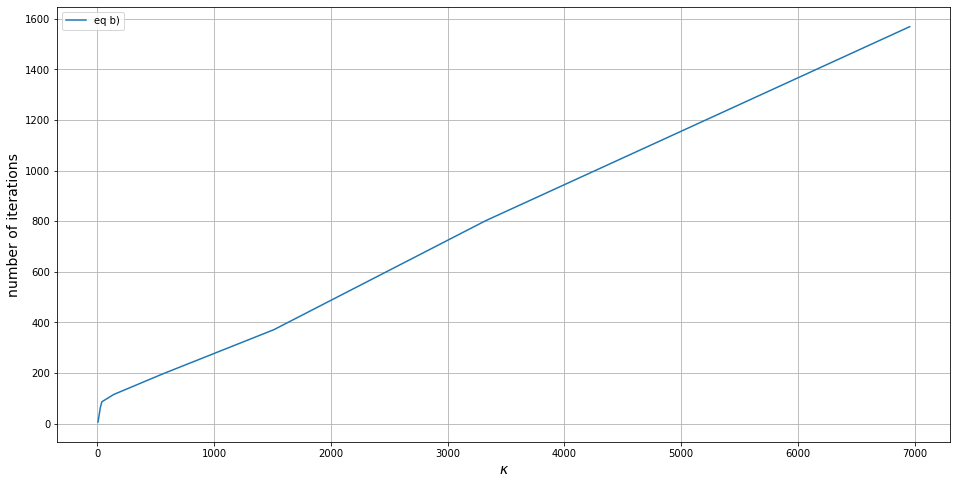

In [16]:

plt.figure(figsize=(16,8))
fs_axis = 14
#plt.plot(hs_a,num_a, label="eq a)")
plt.plot(hs, num_b, label="eq b)")
#plt.plot(hs, np.power(1/np.array(hs),1), label=r"$\frac{1}{h}$")
plt.legend()
plt.grid()
plt.xlabel("maxh", fontsize=fs_axis)
plt.ylabel(r"number of iterations CG", fontsize=fs_axis);

plt.figure(figsize=(16,8))
fs_axis = 14
#plt.plot(hs_a, kappa_a, label=r"$\kappa$ for a)")
plt.plot(hs, kappa_b, label=r"$\kappa$ for b)")
plt.legend()
plt.grid()
plt.xlabel("maxh", fontsize=fs_axis)
plt.ylabel(r"$\kappa$", fontsize=fs_axis);

plt.figure(figsize=(16,8))
fs_axis = 14
#plt.plot(kappa_a,num_a, label="eq a)")
plt.plot(kappa_b,num_b, label="eq b)")
plt.legend()
plt.grid()
plt.xlabel(r"$\kappa$", fontsize=fs_axis)
plt.ylabel(r"number of iterations", fontsize=fs_axis);

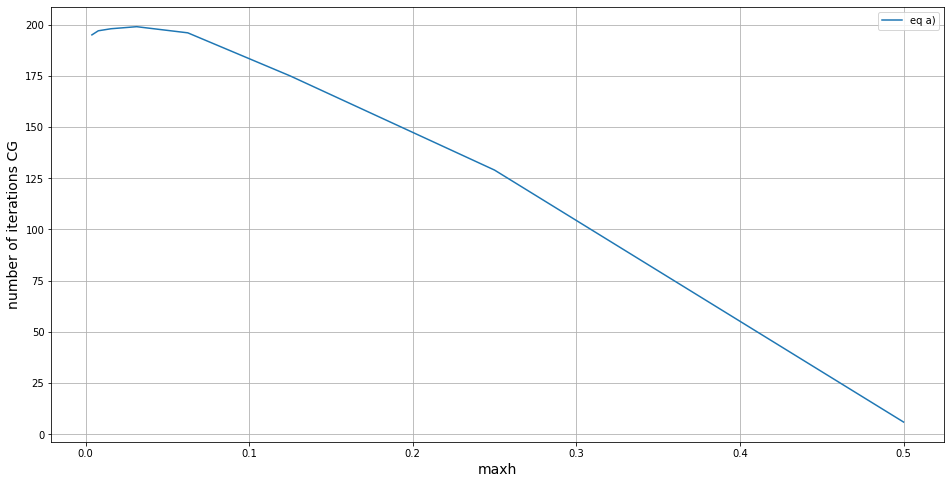

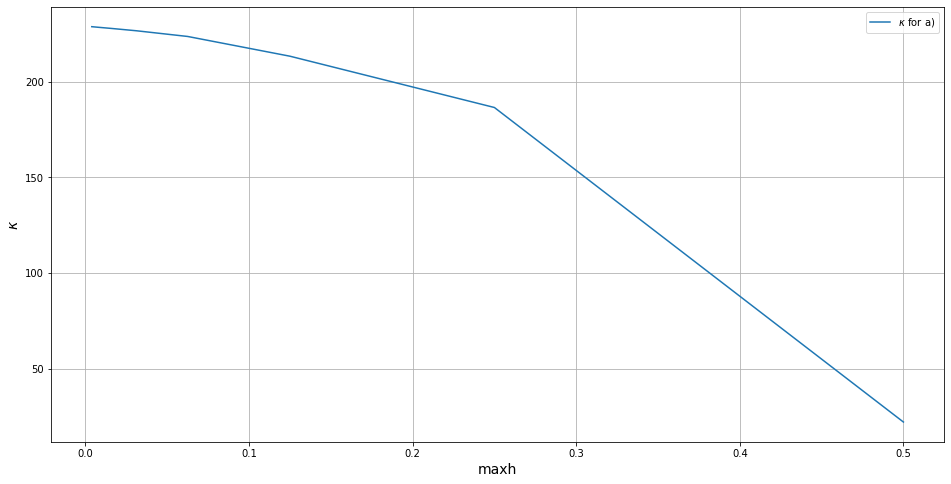

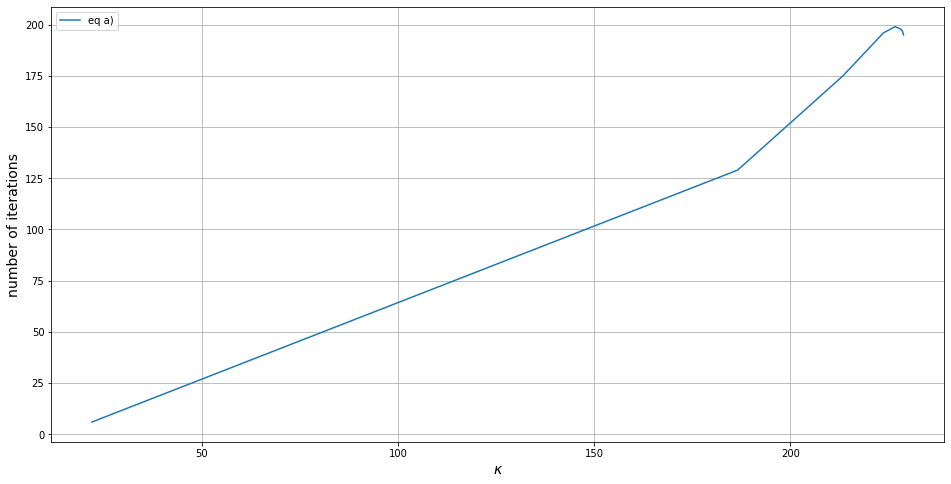

In [13]:
plt.figure(figsize=(16,8))
fs_axis = 14
plt.plot(hs,num_a, label="eq a)")
#plt.plot(hs, num_b, label="eq b)")
plt.legend()
plt.grid()
plt.xlabel("maxh", fontsize=fs_axis)
plt.ylabel(r"number of iterations CG", fontsize=fs_axis);

plt.figure(figsize=(16,8))
fs_axis = 14
plt.plot(hs, kappa_a, label=r"$\kappa$ for a)")
#plt.plot(hs[:], np.power(1/np.array(hs), 2), label=r"$\frac{1}{h^2}$")
#plt.plot(hs, kappa_b, label=r"$\kappa$ for b)")
plt.legend()
plt.grid()
plt.xlabel("maxh", fontsize=fs_axis)
plt.ylabel(r"$\kappa$", fontsize=fs_axis);

plt.figure(figsize=(16,8))
fs_axis = 14
plt.plot(kappa_a,num_a, label="eq a)")
#plt.plot(kappa_b,num_b, label="eq b)")
plt.legend()
plt.grid()
plt.xlabel(r"$\kappa$", fontsize=fs_axis)
plt.ylabel(r"number of iterations", fontsize=fs_axis);

In [ ]:
ref_b = [100+7.5/d for d in d_b]

In [ ]:
plt.figure(figsize=(16,8))
fs_title= 18
fs_axis = 14
plt.title("Condition number vs h", fontsize=fs_title)
plt.grid()
plt.xlabel("maxh", fontsize=fs_axis)
#plt.ylabel(r"$\kappa_2$ ...condition number", fontsize=fs_axis);
plt.ylabel("number of iterations (of CG)", fontsize=fs_axis)
plt.plot(hs,num_a,label=r'$\kappa_2$...cond number of the massmatrix')
plt.plot(hs,num_b,label=r'$\kappa_2$...cond number of the stiffnesmatrix')
plt.plot(hs,ref_b,label=r'estimate $c+\mathcal{O}(1/h)$')
plt.legend();

In [9]:
j = 0
maxlevel = 10
levels = [i for i in range(0,maxlevel)]
num_a = []
kappa_a = []
hs_a = []

mesh = Mesh(unit_square.GenerateMesh(maxh=h))
fes = H1(mesh, order=3,dirichlet=".*")
gfu_a = GridFunction(fes,name = "u_a")
ua = fes.TrialFunction()
va = fes.TestFunction()

Aa = BilinearForm(fes)
Fa = LinearForm(fes)

Aa += ua*va*dx

Fa += va*dx

Aa.Assemble()
Fa.Assemble()

c = Preconditioner(Aa,"local",test = True)


for level in levels:
    if level > 0:
        mesh.Refine()
        
    fes.Update()
    gfu_a.Update()
    h = fes.ndof
    print("maxh:",h)
    Aa.Assemble()
    Fa.Assemble()
    c.Update()
    data = []
    callback = lambda k,r: data.append((k,r))
    #gfu_a.vec.data = Aa.mat.Inverse(fes.FreeDofs()) * Fa.vec

    with TaskManager():
        CG (mat=Aa.mat, pre=c.mat, rhs=Fa.vec, sol=gfu_a.vec, printrates=False, maxsteps=10000, tol=1e-15, callback = callback)
    
    hs_a.append(h)
    num_a.append(len(data))
    lams = EigenValues_Preconditioner(mat=Aa.mat, pre=c)
    kappa_a.append(max(lams)/min(lams))

print("Iterations:", maxlevel)
Draw (mesh)
Draw(gfu_a)

maxh: 105037
maxh: 418945
maxh: 1673377
maxh: 6688705
maxh: 26745217


KeyboardInterrupt: 